# Problem:  How to supply a set of 'demand nodes' with a resource

Given for $node_k$  
- Location of demand:  $x_k, y_k$
- Number of households to supply to:  $households_k$


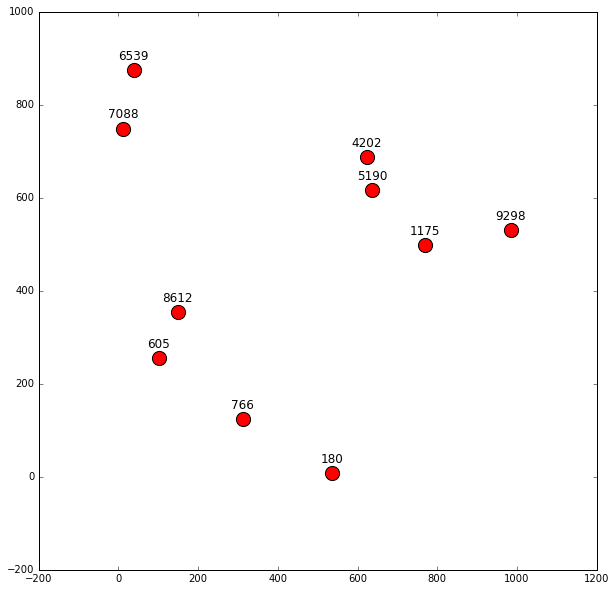

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
"""
Run through of simple networkplanner scenario
"""
import numpy as np
import pandas as pd
import networkx as nx
from networker.classes.geograph import GeoGraph
from networker import utils, networker_runner

"""
Given a set of \"Demand Nodes\" over a region

For simplicity, assume all have 0 supply
"""

def random_points(num_points, upto):
    x = np.random.randint(upto, size=num_points)
    y = np.random.randint(upto, size=num_points)
    return np.array([x, y]).T

def new_geograph(coords, dataframe):
    geo_nodes = GeoGraph(coords=coords)
    for col in dataframe.columns:
        for node in geo_nodes:
            geo_nodes.node[node][col] = dataframe[col][node]
    return geo_nodes

NUM_NODES = 10
REGION_WIDTH = 1000

coords = random_points(NUM_NODES, REGION_WIDTH)
# TODO:  vary the distribution
demand_nodes = pd.DataFrame({'households': np.random.randint(20, high=10000, size=10)})
geo_nodes = new_geograph(coords, demand_nodes)
    
#plot
utils.draw_geograph(geo_nodes, node_label_field='households', node_label_y_offset=30)

## Simple Supply and Distribution costs 

Parameters:
- Cost for standalone supply:  $SupplyCostPerHH$
- Cost for standalone distribution:  $DistrCostPerHH$

for $node_k$:

- $supply_k = households_k * SupplyCostPerHH$
- $distribution_k = households_k * DistrCostPerHH$
- $standalone_k = supply_k + distribution_k$

- $total = \sum_{k=1}^n standalone_k$

total standalone Cost: 109.3M


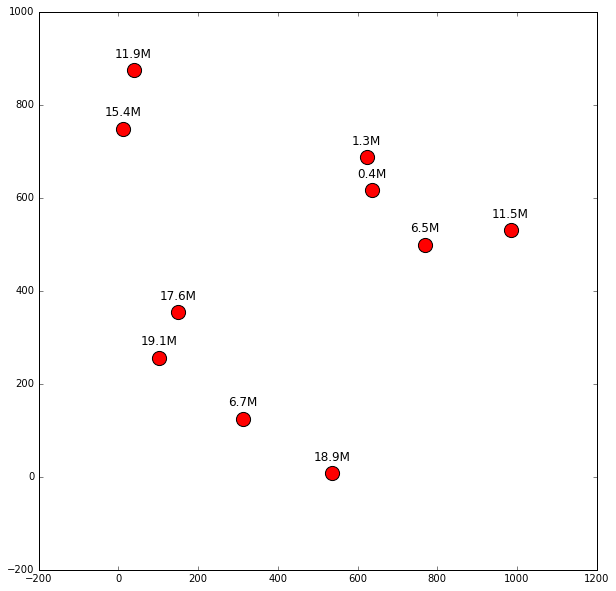

In [4]:
plt.figure(figsize=(10, 10))
SUPPLY_COST_PER_HH = 1500
DISTR_COST_PER_HH = 500

demand_nodes = pd.DataFrame({'households': np.random.randint(20, high=10000, size=10)})
demand_nodes['supply'] = demand_nodes.households * SUPPLY_COST_PER_HH
demand_nodes['distribution'] = demand_nodes.households * DISTR_COST_PER_HH
demand_nodes['standalone'] = demand_nodes.supply + demand_nodes.distribution
demand_nodes['standalone_millions'] = ["%.1fM" % (cost / 1e6) for cost in demand_nodes.standalone]

total_standalone = sum(demand_nodes.standalone)
geo_nodes = new_geograph(coords, demand_nodes)

utils.draw_geograph(geo_nodes, node_label_field='standalone_millions', node_label_y_offset=35)
print("total standalone Cost: %.1fM" % (total_standalone / 1e6))

# What if we share supply *between* nodes? 

Cheapest way to connect everyone is a Minimum Spanning Tree

- $connection_k = distance_k * LineCostPerKM$

- $grid_k = connection_k + distribution_k$

- $total = \sum_{k=1}^n grid_k$

line cost per unit distance: 30.0K
total grid: 92.3M


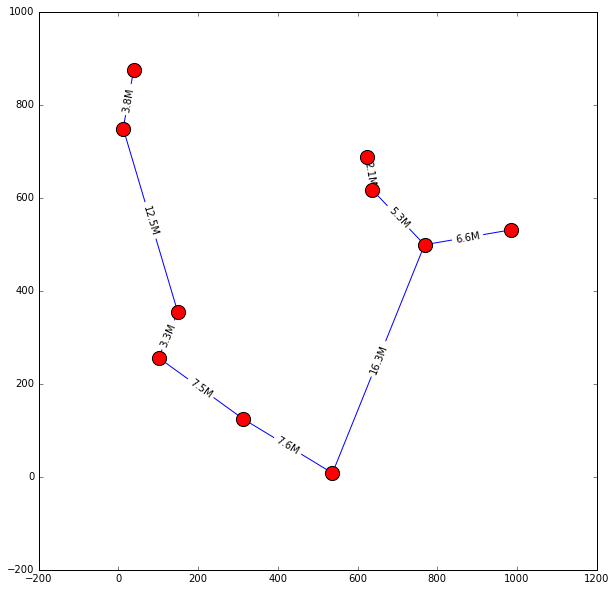

In [19]:
plt.figure(figsize=(10, 10))
geo_nodes = GeoGraph(coords=coords)
geo_full = geo_nodes.get_connected_weighted_graph()
geo_mst = nx.minimum_spanning_tree(geo_full)
geo_nodes.add_edges_from(geo_mst.edges(data=True))

total_supply = sum(demand_nodes.supply)
total_distribution = sum(demand_nodes.distribution)
average_supply = total_supply / NUM_NODES
average_standalone = total_standalone / NUM_NODES

total_line_length = sum(e[2]['weight'] for e in geo_nodes.edges(data=True))
# Set line cost by MST line length
mean_inter_node_dist = total_line_length / NUM_NODES
# Set line cost by region dimensions
# mean_inter_node_dist = ((2**(1/2))*REGION_WIDTH) / NUM_NODES
# line_cost_per_unit_dist = average_supply / mean_inter_node_dist
# Set it via intuition
line_cost_per_unit_dist = 3e4

for e in geo_nodes.edges(data=True):
    e[2]['grid_cost_millions'] = ("%.1fM" % ((e[2]['weight'] * line_cost_per_unit_dist) / 1e6))

utils.draw_geograph(geo_nodes, edge_label_field='grid_cost_millions')

total_grid = (total_line_length * line_cost_per_unit_dist) + total_distribution

print("line cost per unit distance: %.1fK" % (line_cost_per_unit_dist/ 1e3))
print("total grid: %.1fM" % (total_grid / 1e6))


## Can we do better by selecting cheapest?

Now
- $total = \sum_{k=1}^n standalone_k[standalone_k < grid_k] + grid_k[grid_k < standalone_k]$

We want to minimize this

Our approach is to modify the Minimum Spanning Tree:

Assign 'budget' to each node (called 'mvMax' in electrification planning) that can be used for connection to grid:
- $(grid_k = connection_k + distribution_k) < (standalone_k = supply_k + distribution_k)$
- So the budget for connecting to grid is:  $budget_k = ( standalone_k - distribution_k ) = (supply_k)$
- $budgetDistance_k = \frac{budget_k}{LineCostPerKM}$

Add 'two-way' test criteria to each edge check in MST algorithm
for edge (i, j):  
- $dist(i, j) < budgetDistance_i \land dist(i, j) < budgetDistance_j$

Increase 'budget' with each new *component* connection:
for new component c joining components i, j:
- $budget_c = (budgetDistance_i + budgetDistance_j) - dist(i, j)$

2016-08-30 09:52:38,213 - networker - INFO - running mod_boruvka on 10 demand nodes and 10 total nodes
2016-08-30 09:52:38,249 - networker - INFO - filtered result has 10 nodes and 3 edges


standalone: 45.2M, grid 35.7M, total: 80.9M


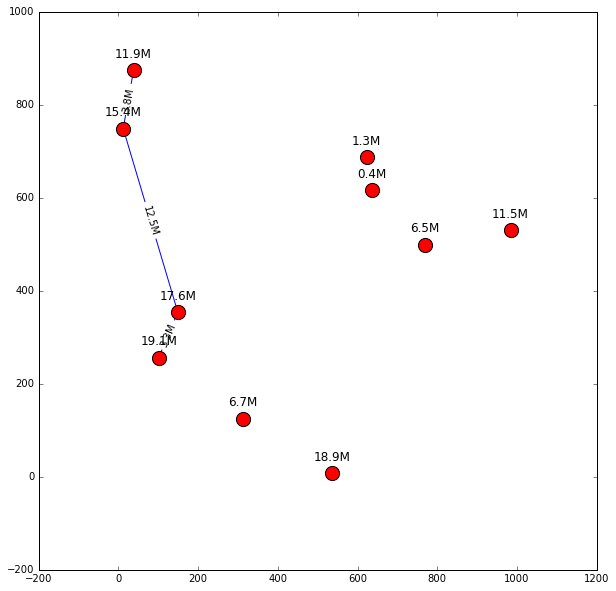

In [18]:
plt.figure(figsize=(10, 10))
geo_nodes = new_geograph(coords, demand_nodes)
for node in geo_nodes.nodes_iter():
    geo_nodes.node[node]['budget'] = demand_nodes.supply[node] / line_cost_per_unit_dist

msf = networker_runner.build_network(geo_nodes, min_node_count=0)
geo_nodes.add_edges_from(msf.edges(data=True))

non_grid_nodes = [node for node in geo_nodes.nodes_iter() if len(geo_nodes.edge[node]) == 0]
grid_nodes = [node for node in geo_nodes.nodes_iter() if len(geo_nodes.edge[node]) > 0]
total_distr_grid = sum(demand_nodes.distribution[node] for node in grid_nodes)

total_mod_standalone = sum(demand_nodes.supply[node] + 
                           demand_nodes.distribution[node] 
                           for node in non_grid_nodes)

total_line_length = sum(e[2]['weight'] for e in geo_nodes.edges(data=True))
total_mod_grid = total_line_length * line_cost_per_unit_dist + total_distr_grid
for e in geo_nodes.edges(data=True):
    e[2]['grid_cost_millions'] = ("%.1fM" % ((e[2]['weight'] * line_cost_per_unit_dist) / 1e6))
    
utils.draw_geograph(geo_nodes, node_label_field='standalone_millions', edge_label_field='grid_cost_millions', node_label_y_offset=35)    

total_mod = total_mod_standalone + total_mod_grid
print("standalone: %.1fM, grid %.1fM, total: %.1fM" % (total_mod_standalone / 1e6, total_mod_grid / 1e6, total_mod / 1e6))